
Authors: Paula Biderman Mato and Pablo Fuentes Chemes


# Language Modelling
# Lab Assignment: Neural models for word vector representation.

# Introduction
In this notebook, we develop and train a word embedding model designed to predict a central word based on its surrounding context.
The model is trained on a corpus of 30,000 news sentences and aims to learn semantic representations of words.
Additionally, we evaluate the quality of the embeddings through qualitative analysis (cosine similarity, t-SNE visualization) and quantitative analysis (text classification on Reuters dataset).

# 1. Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Lambda, Dense, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


## 2. Load the Dataset 
Define the path to the dataset containing 30,000 English news sentences.
Each line in the file corresponds to a single sentence.

In [2]:
# Path to dataset
DATA_PATH = 'eng_news_2024_30k_sentences.txt'

## Read Raw Sentences
Open the dataset file and read all sentences into a list. Empty lines are skipped to avoid invalid entries. Print the number of sentences loaded and display a few examples.

In [3]:
# Read raw sentences
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    sentences = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(sentences)} sentences.")
print(sentences[:5])

Loaded 30000 sentences.
['$10-$15 suggested donation goes to Falmouth Land Trust.', '$20,000: Lower Adirondack Pride Festival, June 1 in City Park, Glens Falls.', '$239.4 billion (32nd), comparable to Hungary.', '$35, $75 family of three or more.', '£1,200: Provision of funding for Year 1 & Year 2 children to attend Enchantica Christmas Show / Grove Road Community Primary School.']


# 3. Preprocessing and Training Sample Generation

To prepare the training data, we first tokenize the sentences using a Keras Tokenizer, limiting the vocabulary size to the 20,000 most frequent words. Each sentence is converted into a sequence of integer word indices.

Then, for each target word within a sentence, we extract its context consisting of two words before and two words after it (a context window size of 2).

We create training examples where the input is the list of context words and the output is the target word to be predicted.

Finally, the dataset is split into training and validation sets, with 90% of the examples used for training and 10% for validation.

In [36]:
# Define model parameters
context_window = 2  #n words on each side of the target word
#vocab_size = 20000 #limit the vocabulary size to the top 20,000 words
vocab_size=5000
maxlen = context_window * 2 #total number of context words (left + right)
 
# Tokenize the sentences
# Initialize a Keras Tokenizer and fit it on the loaded sentences. Each word will be assigned a unique integer index.
# OOV (out of vocabulary) token is used for rare words.
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

# Generate Context-Target training pairs
inputs, targets = [], [] #Input: the context words (2 words before and 2 after the target word); Target: the center word to predict
for seq in sequences:
    for i in range(context_window, len(seq) - context_window):
        context = seq[i-context_window:i] + seq[i+1:i+1+context_window]
        target = seq[i]
        if len(context) == maxlen:
            inputs.append(context)
            targets.append(target)
inputs = np.array(inputs) 
#targets = tf.keras.utils.to_categorical(targets, num_classes=vocab_size) #ocupa mucha memoria
targets = np.array(targets) #para ocupe menos memoria
print(f"Samples: {inputs.shape[0]}")

# Train/Validation Split (90%-10%)
x_train, x_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.1, random_state=42)

Vocabulary size: 46640
Samples: 484312


# 4. Build the Context-Prediction Model

We build a context prediction model where the input is a fixed-size window of context words surrounding a target word.

Each context word is embedded into a 100-dimensional vector using an embedding layer.
The embeddings of the context words are averaged to create a single vector representation of the context.

This averaged vector is passed through a fully connected hidden layer with 128 neurons and ReLU activation.
Finally, the model outputs a probability distribution over the vocabulary using a softmax activation.

The model is compiled with categorical cross-entropy loss and the Adam optimizer.

In [37]:
from tensorflow.keras.layers import BatchNormalization

# define embedding dimension
embedding_dim = 100

# input layer: receives 4 context words (2 left + 2 right)
input_layer = Input(shape=(maxlen,))
# embedding layer: transforms word indices into dense vectors
emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, name='embedding')(input_layer)
# average the context word embeddings
avg = Lambda(lambda x: tf.reduce_mean(x, axis=1))(emb)
# hidden dense layer with 128 units and ReLU activation
#hidden = Dense(128, activation='relu')(avg)
# Hidden layers with regularization
hidden = Dense(256, activation='relu')(avg)
hidden = BatchNormalization()(hidden)  # Normalize activations
hidden = Dropout(0.5)(hidden)            # 50% Dropout

hidden = Dense(128, activation='relu')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Dropout(0.5)(hidden)
# output layer: predicts the target word (softmax over vocabulary)
out = Dense(vocab_size, activation='softmax')(hidden)

# define, compile and display the model
model = Model(inputs=input_layer, outputs=out)
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 4, 100)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 5000)           │       645,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205,288 (4.60 MB)

 Trainable params: 1,204,520 (4.59 MB)

 Non-trainable params: 768 (3.00 KB)

# 5. Train the Context Prediction Model

The model is trained using the prepared context-target pairs.
We use a batch size of 128 and train the model for 5 epochs.
10% of the training data is used as a validation set to monitor the model's performance during training.
The training history, including accuracy and loss metrics for both training and validation sets, is stored for further analysis.

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,          # Si en 3 epochs no mejora el val_loss, paramos
    restore_best_weights=True
)
# define training parameters
batch_size = 64
epochs = 50

# train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/50
6811/6811 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.1362 - loss: 6.3491 - val_accuracy: 0.1824 - val_loss: 5.5244
Epoch 2/50
6811/6811 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.1772 - loss: 5.5762 - val_accuracy: 0.1945 - val_loss: 5.3630
Epoch 3/50
6811/6811 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.1896 - loss: 5.4188 - val_accuracy: 0.1992 - val_loss: 5.2835
Epoch 4/50
6811/6811 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.1955 - loss: 5.3321 - val_accuracy: 0.2041 - val_loss: 5.2316
Epoch 5/50
6811/6811 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.1998 - loss: 5.2610 - val_accuracy: 0.2068 - val_loss: 5.1993
Epoch 6/50
6811/6811 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.2018 - loss: 5.2260 - val_accuracy: 0.2084 - val_loss: 5.1674
Epoch 7/50
6811/6811 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.2051 - loss: 5.1896 - val_accuracy: 0.2107 - val_loss: 5.1481
Epoch 8/50
6811/6811 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.2072 - loss: 5

### Plot Training and Validation Accuracy and Loss

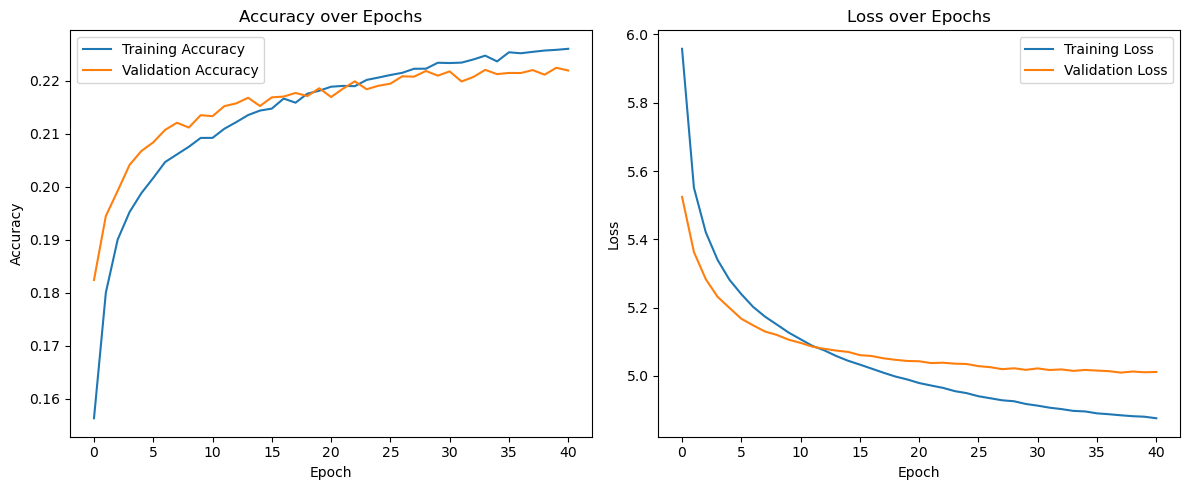

In [39]:
import matplotlib.pyplot as plt

# plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 6. Extract and Save Learned Embeddings

After training, we extract the embedding matrix from the trained model.
This matrix contains the dense vector representations learned for each word in the vocabulary.
The embeddings are saved to a .npy file so that they can be reused for further qualitative analysis (cosine similarity, t-SNE visualization) and downstream tasks (text classification).

In [40]:
#extract the weights from the embedding layer
embeddings = model.get_layer('embedding').get_weights()[0]
np.save('trained_embeddings.npy', embeddings) #save for later use
print('Saved embeddings matrix of shape', embeddings.shape)

Saved embeddings matrix of shape (5000, 100)


# 7. Qualitative Analysis: Cosine Similarity

To evaluate the semantic quality of the learned embeddings, we compute cosine similarity between selected target words and all words in the vocabulary.
For each target word, we retrieve the top 10 most similar words according to their cosine similarity scores.
This analysis helps verify whether the model has successfully learned meaningful semantic relationships between words.

In [41]:
# load the list of target words for analysis
#with open('/mnt/data/target_words.txt') as f:
#    target_words = [w.strip() for w in f]
with open('target_words.txt') as f:
    target_words = [w.strip() for w in f]

# for each target word, find the top 10 most similar words
for word in target_words[:10]:
    if word in tokenizer.word_index and tokenizer.word_index[word] < vocab_size:
        idx = tokenizer.word_index[word]
        # compute cosine similarities between the target word and all embeddings
        sims = cosine_similarity([embeddings[idx]], embeddings)[0]
        # get indices of the top 10 most similar words
        top_indices = sims.argsort()[-11:-1][::-1]
        # retrieve the words corresponding to the indices
        similar = [tokenizer.index_word[i] for i in top_indices]
        print(f"{word}: {similar}")


everyone: ['everything', 'anyone', 'me', 'visitors', 'residents', 'immigrants', 'biden', 'them', 'republicans', 'things']
music: ['heights', 'prevention', 'friends', 'occasionally', 'luxury', 'youth', 'racist', 'joy', 'bodies', 'tim']
running: ['boxing', 'odds', 'display', 'welcoming', 'asked', 'philadelphia', 'defending', 'performing', 'swept', 'falling']
worse: ['bigger', 'less', 'better', 'more', 'faster', 'rather', 'easier', 'harder', 'closer', 'herself']
friday: ['monday', 'wednesday', 'tuesday', 'thursday', 'sunday', 'saturday', 'instagram', 'focused', 'nov', 'campus']
september: ['april', 'february', 'october', 'july', 'june', 'march', 'august', 'november', 'feb', 'aug']
someone: ['everybody', 'italy', 'us', 'owners', 'somebody', 'something', 'happiness', 'others', 'myself', 'anything']
getting: ['doing', 'tough', 'often', 'looking', 'being', 'playing', 'stepping', 'driving', 'learning', 'walking']
reported: ['claimed', 'noted', 'confirmed', 'ruled', 'earned', 'mentioned', 'warn

# 8. Qualitative Visualization: t-SNE

To further visualize the structure of the learned embedding space, we apply t-SNE dimensionality reduction to project the high-dimensional word vectors into two dimensions.
We select a subset of target words and plot their embeddings in 2D space.
Words that are semantically related should appear closer together in the visualization, indicating that the embeddings capture meaningful relationships.

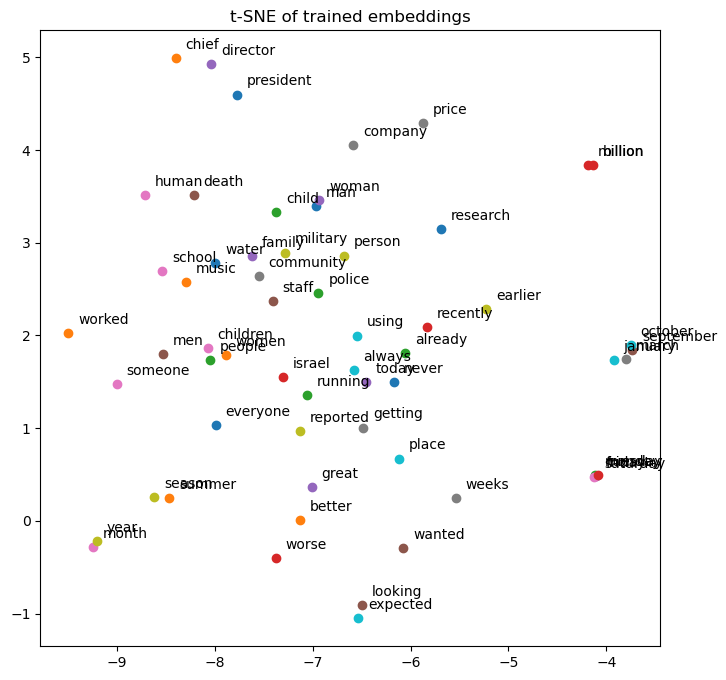

In [42]:
# sample a subset of embeddings for TSNE
sample_indices = [tokenizer.word_index[w] for w in target_words if w in tokenizer.word_index]
sample_vecs = embeddings[sample_indices]
# apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
low_dim = tsne.fit_transform(sample_vecs)

# plot the t-SNE results
plt.figure(figsize=(8, 8))
for i, word in enumerate(target_words[:100]):
    if word in tokenizer.word_index:
        plt.scatter(low_dim[i, 0], low_dim[i, 1])
        plt.text(low_dim[i, 0]+0.1, low_dim[i, 1]+0.1, word)
plt.title('t-SNE of trained embeddings')
plt.show()

# 9. Quantitative Analysis: Text Classification

To quantitatively evaluate the quality of the learned embeddings, we apply them to a downstream text classification task using the Reuters news dataset.

We build two models:
* A baseline model with randomly initialized embeddings.
* A pretrained model using the embeddings learned from the context prediction task.

Both models are convolutional neural networks trained to classify news articles into 46 different categories.
We compare the test set accuracy of both models to assess the impact of pretrained embeddings.

In [44]:
vocab_size

5000

In [50]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

# Load Reuters dataset
# num_words limits the vocabulary to the most frequent 20,000 words
(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=vocab_size)

# pad sequences to a fixed length
maxlen_cls = 256
x_train_r = pad_sequences(x_train_r, maxlen=maxlen_cls)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen_cls)

# convert labels to one-hot encoding
y_train_r = to_categorical(y_train_r)
y_test_r = to_categorical(y_test_r)

# number of output classes
num_classes = y_train_r.shape[1]

# build the Text Classification Model
# define function to build the classification model
def build_classification_model(use_pretrained=True):
    model_cls = Sequential()
    
    # embedding layer
    if use_pretrained:
        # use pretrained embeddings (not trainable)
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                weights=[embeddings], trainable=False, input_length=maxlen_cls))
    else:
        # use randomly initialized embeddings
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                input_length=maxlen_cls))
    # convolutional and pooling layers
    model_cls.add(Conv1D(128, 5, activation='relu'))
    model_cls.add(MaxPooling1D(5))
    model_cls.add(Conv1D(128, 5, activation='relu'))
    model_cls.add(GlobalMaxPooling1D())
    # fully connected layer
    model_cls.add(Dense(128, activation='relu'))
    model_cls.add(Dropout(0.5))
    # output layer
    model_cls.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model_cls.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model_cls

# Train and Evaluate the Models
# train baseline model (random embeddings)
model_base = build_classification_model(use_pretrained=False)
history_base = model_base.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128)

# train model with pretrained embeddings
model_pre = build_classification_model(use_pretrained=True)
history_pre = model_pre.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128)

# evaluate both models on the test set
baseline_accuracy = model_base.evaluate(x_test_r, y_test_r)[1]
pretrained_accuracy = model_pre.evaluate(x_test_r, y_test_r)[1]

print('Baseline Test Accuracy:', baseline_accuracy)
print('Pretrained Embeddings Test Accuracy:', pretrained_accuracy)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3237 - loss: 2.8833 - val_accuracy: 0.5006 - val_loss: 1.9131
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5281 - loss: 1.8431 - val_accuracy: 0.5740 - val_loss: 1.6800
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5843 - loss: 1.6372 - val_accuracy: 0.5984 - val_loss: 1.5613
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6253 - loss: 1.4199 - val_accuracy: 0.6251 - val_loss: 1.5087
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6612 - loss: 1.2943 - val_accuracy: 0.6707 - val_loss: 1.4079
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7350 - loss: 1.0429 - val_accuracy: 0.6808 - val_loss: 1.3723
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7588 - loss: 0.9373 - val_accuracy: 0.7019 - val_loss: 1.3713
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7904 - loss: 0.7943 - val_accuracy: 0.6986 - v

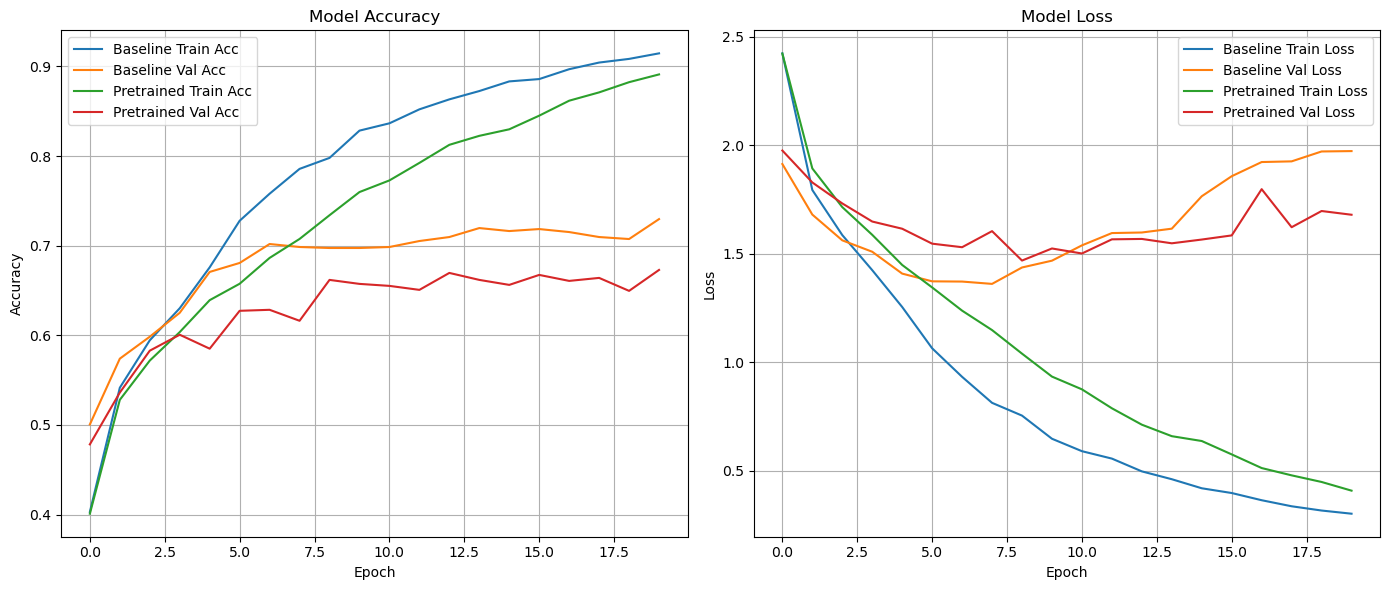

In [51]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Baseline Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(history_pre.history['accuracy'], label='Pretrained Train Acc')
plt.plot(history_pre.history['val_accuracy'], label='Pretrained Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Baseline Train Loss')
plt.plot(history_base.history['val_loss'], label='Baseline Val Loss')
plt.plot(history_pre.history['loss'], label='Pretrained Train Loss')
plt.plot(history_pre.history['val_loss'], label='Pretrained Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [52]:
#otra prueba
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

# Load Reuters dataset
# num_words limits the vocabulary to the most frequent 20,000 words
(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=vocab_size)

# pad sequences to a fixed length
maxlen_cls = 256
x_train_r = pad_sequences(x_train_r, maxlen=maxlen_cls)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen_cls)

# convert labels to one-hot encoding
y_train_r = to_categorical(y_train_r)
y_test_r = to_categorical(y_test_r)

# number of output classes
num_classes = y_train_r.shape[1]

# build the Text Classification Model
# define function to build the classification model
def build_classification_model(use_pretrained=True):
    model_cls = Sequential()
    
    # embedding layer
    if use_pretrained:
        # use pretrained embeddings (not trainable)
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                weights=[embeddings], trainable=False, input_length=maxlen_cls))
    else:
        # use randomly initialized embeddings
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                input_length=maxlen_cls))
    # convolutional and pooling layers
    model_cls.add(Conv1D(256, 5, activation='relu'))
    model_cls.add(MaxPooling1D(5))
    model_cls.add(Conv1D(256, 5, activation='relu'))
    model_cls.add(GlobalMaxPooling1D())
    # fully connected layer
    model_cls.add(Dense(128, activation='relu'))
    model_cls.add(Dropout(0.5))
    # output layer
    model_cls.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model_cls.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model_cls

# Train and Evaluate the Models
# train baseline model (random embeddings)
model_base = build_classification_model(use_pretrained=False)
history_base = model_base.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128)

# train model with pretrained embeddings
model_pre = build_classification_model(use_pretrained=True)
history_pre = model_pre.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128)

# evaluate both models on the test set
baseline_accuracy = model_base.evaluate(x_test_r, y_test_r)[1]
pretrained_accuracy = model_pre.evaluate(x_test_r, y_test_r)[1]

print('Baseline Test Accuracy:', baseline_accuracy)
print('Pretrained Embeddings Test Accuracy:', pretrained_accuracy)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3361 - loss: 2.8190 - val_accuracy: 0.5139 - val_loss: 1.8485
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5438 - loss: 1.7885 - val_accuracy: 0.6051 - val_loss: 1.6071
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.6239 - loss: 1.5115 - val_accuracy: 0.6541 - val_loss: 1.4694
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.6828 - loss: 1.2776 - val_accuracy: 0.6874 - val_loss: 1.3711
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.7244 - loss: 1.0951 - val_accuracy: 0.6897 - val_loss: 1.3861
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7584 - loss: 0.9524 - val_accuracy: 0.6830 - val_loss: 1.4044
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.7766 - loss: 0.8574 - val_accuracy: 0.6963 - val_loss: 1.4883
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.7997 - loss: 0.7535 - val_accuracy: 0.

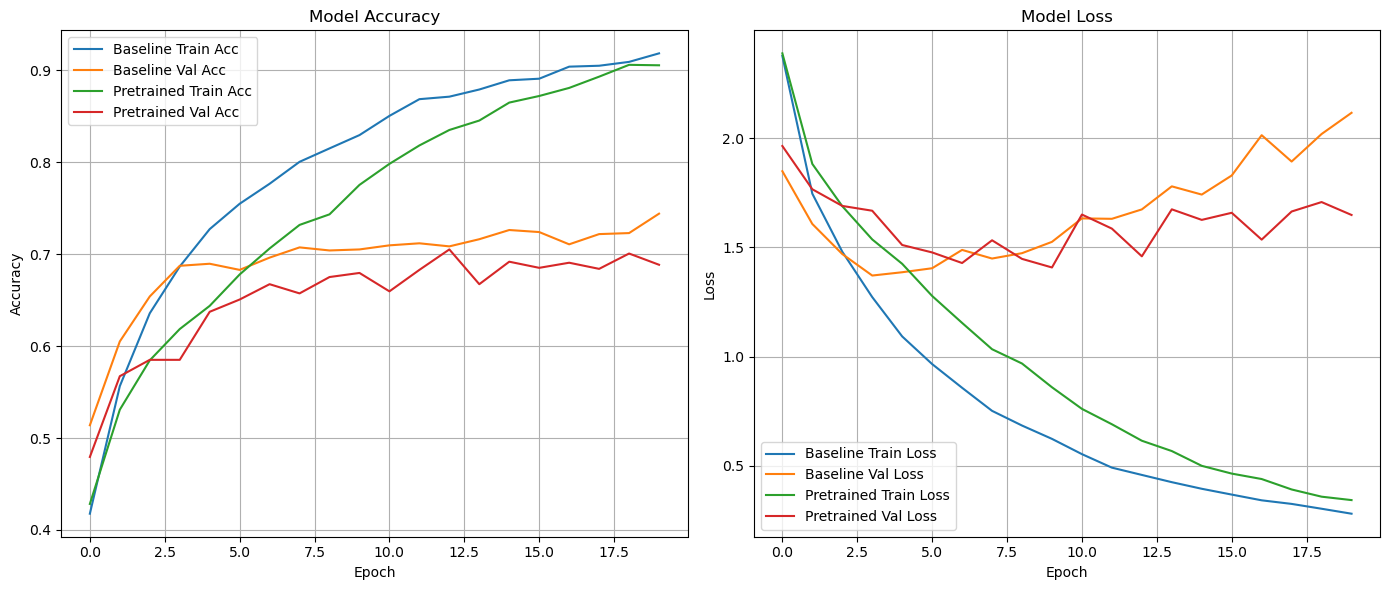

In [53]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Baseline Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(history_pre.history['accuracy'], label='Pretrained Train Acc')
plt.plot(history_pre.history['val_accuracy'], label='Pretrained Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Baseline Train Loss')
plt.plot(history_base.history['val_loss'], label='Baseline Val Loss')
plt.plot(history_pre.history['loss'], label='Pretrained Train Loss')
plt.plot(history_pre.history['val_loss'], label='Pretrained Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [54]:
#otra prueba 

from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

# Load Reuters dataset
# num_words limits the vocabulary to the most frequent 20,000 words
(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=vocab_size)

# pad sequences to a fixed length
maxlen_cls = 256
x_train_r = pad_sequences(x_train_r, maxlen=maxlen_cls)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen_cls)

# convert labels to one-hot encoding
y_train_r = to_categorical(y_train_r)
y_test_r = to_categorical(y_test_r)

# number of output classes
num_classes = y_train_r.shape[1]

# build the Text Classification Model
# define function to build the classification model
def build_classification_model(use_pretrained=True):
    model_cls = Sequential()
    
    # embedding layer
    if use_pretrained:
        # use pretrained embeddings (not trainable)
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                weights=[embeddings], trainable=True, input_length=maxlen_cls)) #cambie trainable a ture
    else:
        # use randomly initialized embeddings
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                input_length=maxlen_cls))
    # convolutional and pooling layers
    model_cls.add(Conv1D(256, 5, activation='relu'))
    model_cls.add(MaxPooling1D(5))
    model_cls.add(Conv1D(256, 5, activation='relu'))
    model_cls.add(GlobalMaxPooling1D())
    # fully connected layer
    model_cls.add(Dense(128, activation='relu'))
    model_cls.add(Dropout(0.5))
    # output layer
    model_cls.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model_cls.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model_cls

# Train and Evaluate the Models
# train baseline model (random embeddings)
model_base = build_classification_model(use_pretrained=False)
history_base = model_base.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128)

# train model with pretrained embeddings
model_pre = build_classification_model(use_pretrained=True)
history_pre = model_pre.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128)

# evaluate both models on the test set
baseline_accuracy = model_base.evaluate(x_test_r, y_test_r)[1]
pretrained_accuracy = model_pre.evaluate(x_test_r, y_test_r)[1]

print('Baseline Test Accuracy:', baseline_accuracy)
print('Pretrained Embeddings Test Accuracy:', pretrained_accuracy)

Epoch 1/20


c:\Users\paulabiderman\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3510 - loss: 2.8176 - val_accuracy: 0.5039 - val_loss: 1.8526
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5375 - loss: 1.7949 - val_accuracy: 0.5907 - val_loss: 1.6364
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5881 - loss: 1.5878 - val_accuracy: 0.6307 - val_loss: 1.5172
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6550 - loss: 1.3927 - val_accuracy: 0.6796 - val_loss: 1.4648
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7049 - loss: 1.2245 - val_accuracy: 0.6908 - val_loss: 1.3599
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7498 - loss: 1.0229 - val_accuracy: 0.6986 - val_loss: 1.3536
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7774 - loss: 0.8678 - val_accuracy: 0.6863 - val_loss: 1.4257
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7973 - loss: 0.7599 - val_accuracy: 0.7063 - val_loss: 1.

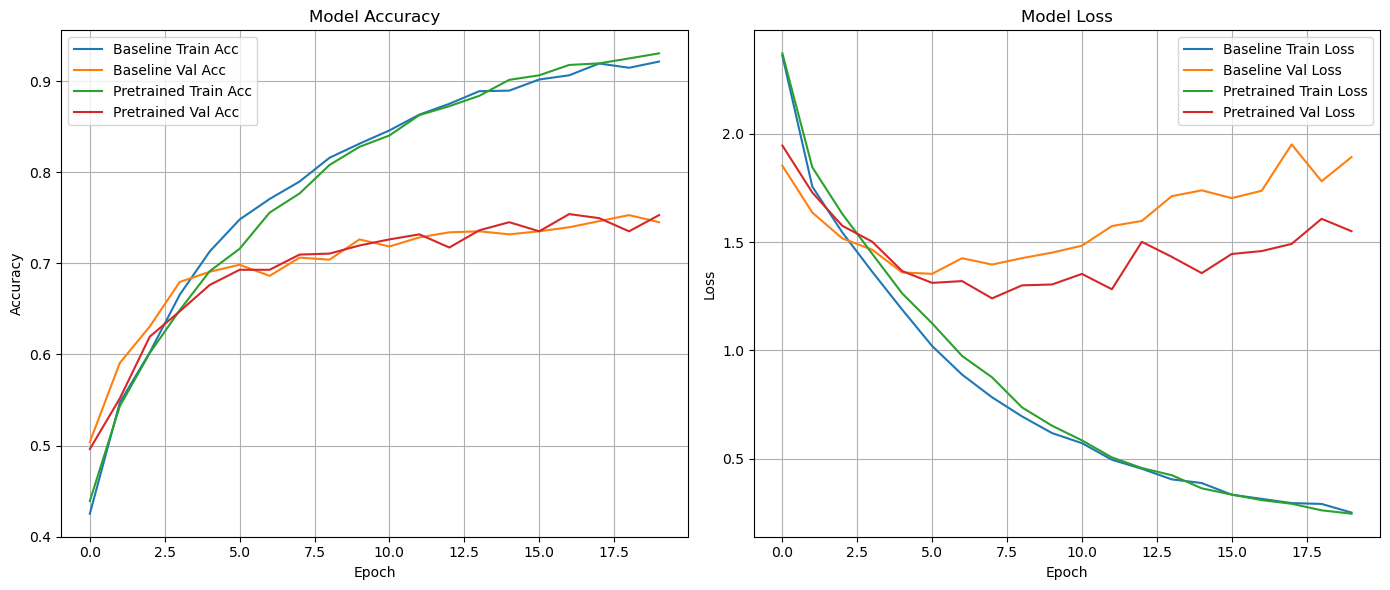

In [55]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Baseline Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(history_pre.history['accuracy'], label='Pretrained Train Acc')
plt.plot(history_pre.history['val_accuracy'], label='Pretrained Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Baseline Train Loss')
plt.plot(history_base.history['val_loss'], label='Baseline Val Loss')
plt.plot(history_pre.history['loss'], label='Pretrained Train Loss')
plt.plot(history_pre.history['val_loss'], label='Pretrained Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [57]:
#otra prueba unificando un poco de todo
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=vocab_size)

# preprocess data
maxlen_cls = 256
x_train_r = pad_sequences(x_train_r, maxlen=maxlen_cls)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen_cls)
y_train_r = to_categorical(y_train_r)
y_test_r = to_categorical(y_test_r)
num_classes = y_train_r.shape[1]

# define model builder functions
def build_model(use_pretrained=False, finetune=False):
    model = Sequential()
    if use_pretrained:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embeddings], trainable=finetune, input_length=maxlen_cls))
    else:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            input_length=maxlen_cls))
    
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# train models
# Baseline (random embeddings)
model_base = build_model(use_pretrained=False)
history_base = model_base.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Pretrained embeddings (frozen)
model_pre = build_model(use_pretrained=True, finetune=False)
history_pre = model_pre.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Pretrained embeddings (fine-tuned)
model_pre_finetuned = build_model(use_pretrained=True, finetune=True)
history_pre_finetuned = model_pre_finetuned.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Evaluate models
baseline_accuracy = model_base.evaluate(x_test_r, y_test_r, verbose=0)[1]
pretrained_accuracy = model_pre.evaluate(x_test_r, y_test_r, verbose=0)[1]
pretrained_finetuned_accuracy = model_pre_finetuned.evaluate(x_test_r, y_test_r, verbose=0)[1]

print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print(f'Pretrained (Frozen) Test Accuracy: {pretrained_accuracy:.4f}')
print(f'Pretrained (Fine-tuned) Test Accuracy: {pretrained_finetuned_accuracy:.4f}')


Epoch 1/20
64/64 - 5s - 81ms/step - accuracy: 0.4356 - loss: 2.3438 - val_accuracy: 0.5117 - val_loss: 1.8258
Epoch 2/20
64/64 - 4s - 58ms/step - accuracy: 0.5564 - loss: 1.7139 - val_accuracy: 0.6051 - val_loss: 1.6140
Epoch 3/20
64/64 - 4s - 57ms/step - accuracy: 0.6117 - loss: 1.4914 - val_accuracy: 0.6374 - val_loss: 1.5127
Epoch 4/20
64/64 - 4s - 58ms/step - accuracy: 0.6740 - loss: 1.3016 - val_accuracy: 0.6752 - val_loss: 1.3698
Epoch 5/20
64/64 - 4s - 60ms/step - accuracy: 0.7225 - loss: 1.1144 - val_accuracy: 0.6785 - val_loss: 1.3973
Epoch 6/20
64/64 - 4s - 55ms/step - accuracy: 0.7512 - loss: 0.9739 - val_accuracy: 0.6897 - val_loss: 1.4355
Epoch 7/20
64/64 - 4s - 55ms/step - accuracy: 0.7857 - loss: 0.8386 - val_accuracy: 0.6997 - val_loss: 1.4127
Epoch 8/20
64/64 - 4s - 59ms/step - accuracy: 0.8056 - loss: 0.7494 - val_accuracy: 0.7086 - val_loss: 1.4449
Epoch 9/20
64/64 - 4s - 59ms/step - accuracy: 0.8214 - loss: 0.6725 - val_accuracy: 0.7008 - val_loss: 1.4591
Epoch 10/2

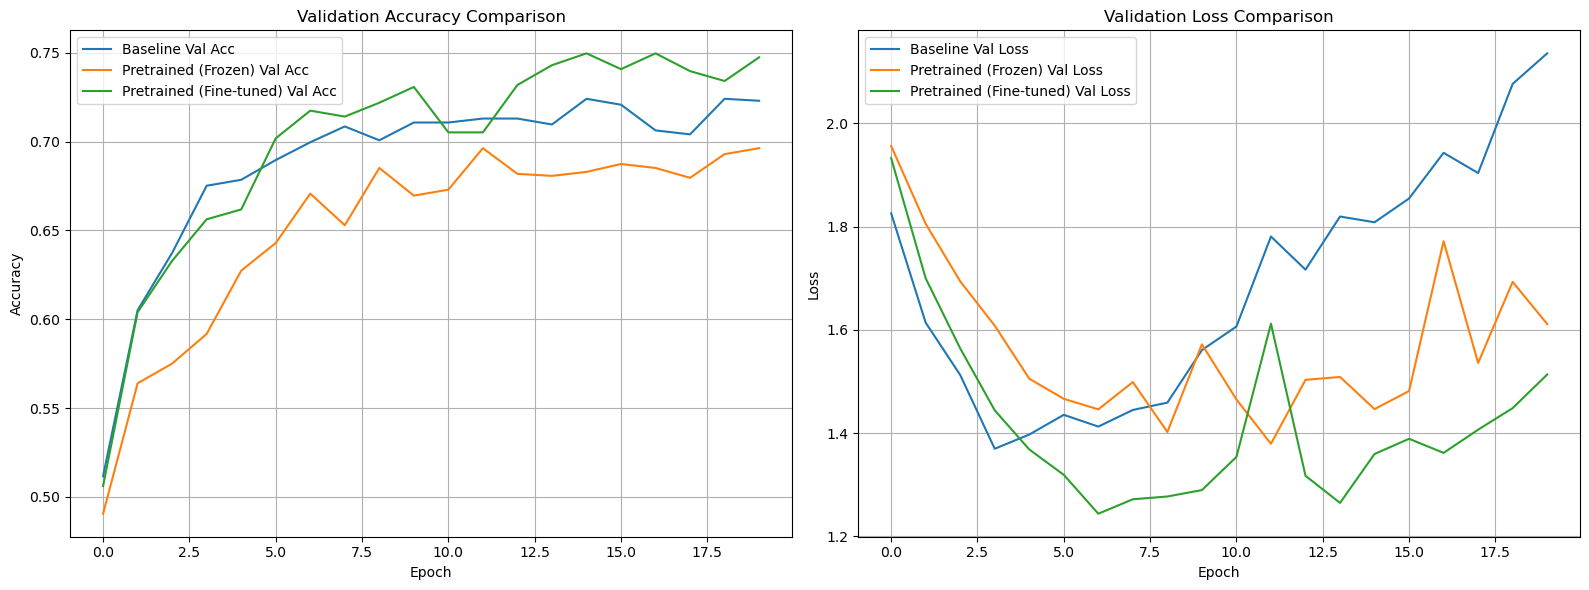

Models saved successfully!


In [58]:
# plot training history
plt.figure(figsize=(16, 6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(history_pre.history['val_accuracy'], label='Pretrained (Frozen) Val Acc')
plt.plot(history_pre_finetuned.history['val_accuracy'], label='Pretrained (Fine-tuned) Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['val_loss'], label='Baseline Val Loss')
plt.plot(history_pre.history['val_loss'], label='Pretrained (Frozen) Val Loss')
plt.plot(history_pre_finetuned.history['val_loss'], label='Pretrained (Fine-tuned) Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# save models
model_base.save('model_baseline.h5')
model_pre.save('model_pretrained_frozen.h5')
model_pre_finetuned.save('model_pretrained_finetuned.h5')

print("Models saved successfully!")

In [47]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

# Load Reuters dataset
# num_words limits the vocabulary to the most frequent 20,000 words
(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=vocab_size)

# pad sequences to a fixed length
maxlen_cls = 256
x_train_r = pad_sequences(x_train_r, maxlen=maxlen_cls)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen_cls)

# convert labels to one-hot encoding
y_train_r = to_categorical(y_train_r)
y_test_r = to_categorical(y_test_r)

# number of output classes
num_classes = y_train_r.shape[1]

# build the Text Classification Model
# define function to build the classification model
def build_classification_model(use_pretrained=True):
    model_cls = Sequential()
    
    # embedding layer
    if use_pretrained:
        # use pretrained embeddings (not trainable)
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                weights=[embeddings], trainable=True, input_length=maxlen_cls))
    else:
        # use randomly initialized embeddings
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                input_length=maxlen_cls))
    # convolutional and pooling layers
    model_cls.add(Conv1D(128, 5, activation='relu'))
    model_cls.add(MaxPooling1D(5))
    model_cls.add(Conv1D(128, 5, activation='relu'))
    model_cls.add(GlobalMaxPooling1D())
    # fully connected layer
    model_cls.add(Dense(128, activation='relu'))
    model_cls.add(Dropout(0.5))
    # output layer
    model_cls.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model_cls.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model_cls

# Train and Evaluate the Models
# train baseline model (random embeddings)
model_base = build_classification_model(use_pretrained=False)
history_base = model_base.fit(x_train_r, y_train_r, validation_split=0.1, epochs=3, batch_size=128)

# train model with pretrained embeddings
model_pre = build_classification_model(use_pretrained=True)
history_pre = model_pre.fit(x_train_r, y_train_r, validation_split=0.1, epochs=3, batch_size=128)

# evaluate both models on the test set
baseline_accuracy = model_base.evaluate(x_test_r, y_test_r)[1]
pretrained_accuracy = model_pre.evaluate(x_test_r, y_test_r)[1]

print('Baseline Test Accuracy:', baseline_accuracy)
print('Pretrained Embeddings Test Accuracy:', pretrained_accuracy)

Epoch 1/3


c:\Users\paulabiderman\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.2893 - loss: 2.9460 - val_accuracy: 0.4972 - val_loss: 1.9303
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5016 - loss: 1.9213 - val_accuracy: 0.5829 - val_loss: 1.6665
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5952 - loss: 1.5803 - val_accuracy: 0.6185 - val_loss: 1.5556
Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3227 - loss: 2.8756 - val_accuracy: 0.4994 - val_loss: 1.9828
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5237 - loss: 1.9309 - val_accuracy: 0.5584 - val_loss: 1.7608
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5859 - loss: 1.7032 - val_accuracy: 0.6096 - val_loss: 1.6330
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6318 - loss: 1.5013
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6210 - loss: 1.5879
Baseline Test Accuracy: 0.6153160929679871
Pretrained Embeddings Test Accuracy: 0.6073018908500671


In [49]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

# Load Reuters dataset
# num_words limits the vocabulary to the most frequent 20,000 words
(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=vocab_size)

# pad sequences to a fixed length
maxlen_cls = 256
x_train_r = pad_sequences(x_train_r, maxlen=maxlen_cls)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen_cls)

# convert labels to one-hot encoding
y_train_r = to_categorical(y_train_r)
y_test_r = to_categorical(y_test_r)

# number of output classes
num_classes = y_train_r.shape[1]

# build the Text Classification Model
# define function to build the classification model
def build_classification_model(use_pretrained=True):
    model_cls = Sequential()
    
    # embedding layer
    if use_pretrained:
        # use pretrained embeddings (not trainable)
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                weights=[embeddings], trainable=True, input_length=maxlen_cls))
    else:
        # use randomly initialized embeddings
        model_cls.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                input_length=maxlen_cls))
    # convolutional and pooling layers
    model_cls.add(Conv1D(256, 5, activation='relu'))
    model_cls.add(MaxPooling1D(5))
    model_cls.add(Conv1D(256, 5, activation='relu'))
    model_cls.add(GlobalMaxPooling1D())
    # fully connected layer
    model_cls.add(Dense(128, activation='relu'))
    model_cls.add(Dropout(0.5))
    # output layer
    model_cls.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model_cls.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model_cls

# Train and Evaluate the Models
# train baseline model (random embeddings)
model_base = build_classification_model(use_pretrained=False)
history_base = model_base.fit(x_train_r, y_train_r, validation_split=0.1, epochs=5, batch_size=128)

# train model with pretrained embeddings
model_pre = build_classification_model(use_pretrained=True)
history_pre = model_pre.fit(x_train_r, y_train_r, validation_split=0.1, epochs=5, batch_size=128)

# evaluate both models on the test set
baseline_accuracy = model_base.evaluate(x_test_r, y_test_r)[1]
pretrained_accuracy = model_pre.evaluate(x_test_r, y_test_r)[1]

print('Baseline Test Accuracy:', baseline_accuracy)
print('Pretrained Embeddings Test Accuracy:', pretrained_accuracy)

Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.3523 - loss: 2.8731 - val_accuracy: 0.5106 - val_loss: 1.8353
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5404 - loss: 1.7870 - val_accuracy: 0.5918 - val_loss: 1.5969
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6107 - loss: 1.4949 - val_accuracy: 0.6552 - val_loss: 1.5059
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6421 - loss: 1.3836 - val_accuracy: 0.6585 - val_loss: 1.4495
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6962 - loss: 1.1858 - val_accuracy: 0.6819 - val_loss: 1.3671
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.3526 - loss: 2.7023 - val_accuracy: 0.4928 - val_loss: 1.9302
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5294 - loss: 1.9035 - val_accuracy: 0.5918 - val_loss: 1.6859
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6019 - loss: 1.6440 - val_accuracy: 0.6151 - val_loss:

# 10. Discussion and Next Steps

- Analyze results: impact of context window, embedding dim, pretrained vs scratch
- Explore larger corpora or external embeddings (fastText, Gensim)
- Document findings and prepare report (max 3 pages)
- Prepare defense slides

Paula ignora lo de abajo que es un archivo que subio el profe, simplemente lo estoy reutilizando

**Two functions that you can use to visualize the embeddings using t-sne**
- visualize_tsne_embeddings: This function plots the embeddings specifically for the selected words.
- visualize_all_tsne_embeddings: This function plots and labels the embeddings for a selection of words, while also including all other embeddings in the visualization.

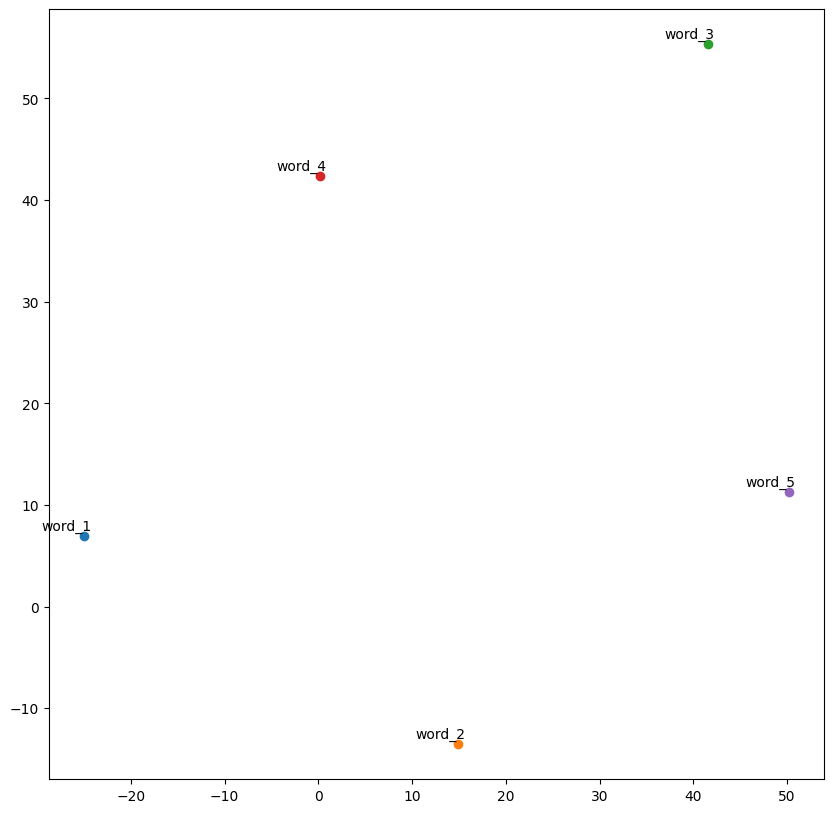

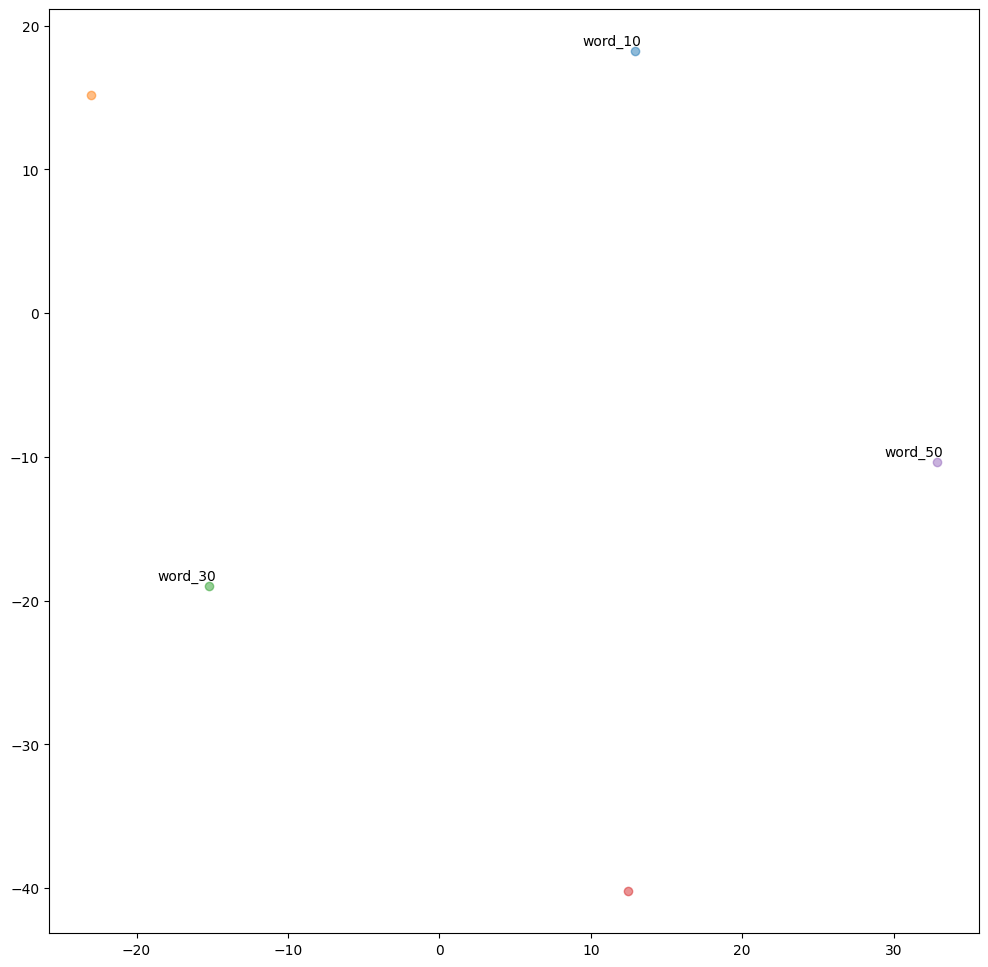

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def visualize_tsne_embeddings(words, embeddings, word_index, filename=None):
    """
    Visualizes t-SNE embeddings of selected words.

    Args:
        words (list): List of words to visualize.
        embeddings (numpy.ndarray): Array containing word embeddings.
        word_index (dict): Mapping of words to their indices in the embeddings array.
        filename (str, optional): File to save the visualization. If None, plot is displayed.

    Returns:
        None
    """
    # Filter the embeddings for the selected words
    indices = [word_index[word] for word in words]
    selected_embeddings = embeddings[indices]

    # Set perplexity for t-SNE, it's recommended to use a value less than the number of selected words
    perplexity = min(5,len(words) - 1)

    # Use t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)

    # Plotting
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')

    # Save or display the plot
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


def visualize_all_tsne_embeddings(embeddings, word_index, words_to_plot, words_to_label=None, filename=None):
    """
    Visualizes t-SNE embeddings of selected words with optional labeling.

    Args:
        embeddings (numpy.ndarray): Array containing word embeddings.
        word_index (dict): Mapping of words to their indices in the embeddings array.
        words_to_plot (list): List of words to plot.
        words_to_label (list, optional): List of words to label. Defaults to None.
        filename (str, optional): File to save the visualization. If None, plot is displayed.

    Returns:
        None
    """
    # Create a reverse mapping from index to word
    index_word = {index: word for word, index in word_index.items()}

    # Ensure words_to_label is a subset of words_to_plot
    if words_to_label is None:
        words_to_label = words_to_plot
    words_to_label = set(words_to_label).intersection(words_to_plot)

    # Filter the embeddings for the words to plot
    indices_to_plot = [word_index[word] for word in words_to_plot if word in word_index]
    selected_embeddings = embeddings[indices_to_plot]

    # Set perplexity for t-SNE, it's recommended to use a value less than the number of selected words
    perplexity = min(5,len(words_to_plot) - 1)

    # Use t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)

    # Plotting
    plt.figure(figsize=(12, 12))
    for i, index in enumerate(indices_to_plot):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], alpha=0.5)
        if index_word[index] in words_to_label:  # Annotate only selected words
            plt.annotate(index_word[index],
                         xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')



# Mock embeddings and word_index
embeddings = np.random.randn(100, 50)  # Mock embeddings with 100 words and 50 dimensions
word_index = {f"word_{i}": i for i in range(100)}  # Mock word index

# Example usage of the first function
def example_plot_1():
    words = ["word_1", "word_2", "word_3", "word_4", "word_5"]  # Select some words to plot
    visualize_tsne_embeddings(words, embeddings, word_index, filename="plot_1.png")

# Example usage of the second function
def example_plot_2():
    words_to_plot = ["word_10", "word_20", "word_30", "word_40", "word_50"]  # Select some words to plot
    words_to_label = ["word_10", "word_30", "word_50"]  # Select some words to label
    visualize_all_tsne_embeddings(embeddings, word_index, words_to_plot, words_to_label, filename="plot_2.png")

example_plot_1()
example_plot_2()